# Markov-Chain Figure Generation
This notebook generates the figures (Metropolis and lifted / event-chain style) used in the paper. 
It builds directed graphs encoding transition structure and renders them with custom curved arrows and LaTeX labels.

## Overview
We construct two graphs:
1. Metropolis chain on a line of states $\pi_1,\dots,\pi_n$ with self-loops and bidirectional neighbor edges weighted by minima or positive parts.
2. Lifted chain with an added directional layer (+ / -) illustrating global balance via irreversible flows.
Custom drawing utilities handle:
- Node layout (two-row arrangement when lifted)
- Curved connection arrows
- Self-loop geometry
- Edge label orientation along arrow direction

## Graph Construction Functions
`create_markov_chain_graph_metropolis(n)` and `create_markov_chain_graph_lifted(n)` return `networkx.DiGraph` objects with symbolic LaTeX labels stored per node/edge.

In [1]:
import networkx as nx

def create_markov_chain_graph_metropolis(n: int = 5) -> nx.DiGraph:
    """Construct a directed Metropolis-style Markov chain on n states.

    Nodes: 0..n-1 each labeled with $\pi_{{i}}$.
    Edges: bidirectional nearest-neighbor edges with weight min(π_i, π_{{i+1}});
           self-loops with positive-part expressions encoding staying probability.

    Parameters
    ----------
    n : int, >=3
        Number of states.

    Returns
    -------
    G : nx.DiGraph
        Populated graph with 'label' attributes on nodes and edges.

    Raises
    ------
    ValueError
        If n < 3 (diagram structure expects >=3).
    """
    if n < 3:
        raise ValueError("n must be 3 or greater to match the diagram's structure")
    G = nx.DiGraph()
    nodes = [f"{i}" for i in range(n)]
    for i in range(n):
        G.add_node(nodes[i], label=fr"$\pi_{{{i+1}}}$")
    # Forward edges
    for i in range(n - 1):
        G.add_edge(nodes[i], nodes[i+1], label=fr"$\frac{{1}}{{2}} \, \mathrm{{min}}(\pi_{{{i+1}}}, \pi_{{{i+2}}})$")
    # Backward edges
    for i in range(n - 1):
        G.add_edge(nodes[i+1], nodes[i], label=fr"$\frac{{1}}{{2}} \,\mathrm{{min}}(\pi_{{{i+1}}}, \pi_{{{i+2}}})$")
    # Self-loops
    i = 0
    G.add_edge(nodes[i], nodes[i], label=fr"$\frac{{1}}{{2}} \, \pi_{{{i+1}}} + \frac{{1}}{{2}} \, [\pi_{{{i+1}}}-\pi_{{{i+2}}}]^{{+}}$")
    for i in range(1, n - 1):
        G.add_edge(nodes[i], nodes[i],
                   label=fr"$\frac{{1}}{{2}} \, [\pi_{{{i+1}}}-\pi_{{{i}}}]^{{+}} + \frac{{1}}{{2}} \, [\pi_{{{i+1}}}-\pi_{{{i+2}}}]^{{+}}$")
    i = n - 1
    G.add_edge(nodes[i], nodes[i], label=fr"$\frac{{1}}{{2}} \, \pi_{{{i+1}}} + \frac{{1}}{{2}} \, [\pi_{{{i+1}}}-\pi_{{{i}}}]^{{+}}$")
    return G

def create_markov_chain_graph_lifted(n: int = 5) -> nx.DiGraph:
    """Construct a lifted (direction-augmented) Markov chain.

    State space duplicated into two layers: (+,i) and (-,i).
    Horizontal edges: forward on + layer left→right, backward on - layer right→left.
    Vertical edges: direction changes with positive-part intensities.

    Parameters
    ----------
    n : int, >=3
        Number of base states.

    Returns
    -------
    G : nx.DiGraph
        Directed lifted graph with symbolic LaTeX labels.

    Raises
    ------
    ValueError
        If n < 3.
    """
    if n < 3:
        raise ValueError("n must be 3 or greater to match the diagram's structure")
    G = nx.DiGraph()
    top = [f"+,{i}" for i in range(n)]
    bottom = [f"-,{i}" for i in range(n)]
    for i in range(n):
        label = fr"$\frac{{\pi_{{{i+1}}}}}{{2}}$"
        G.add_node(top[i], label=label)
        G.add_node(bottom[i], label=label)
    for i in range(n - 1):
        G.add_edge(top[i], top[i+1], label=fr"$\mathrm{{min}}\left(\frac{{\pi_{{{i+1}}}}}{{2}}, \frac{{\pi_{{{i+2}}}}}{{2}}\right)$")
    for i in range(n - 1):
        G.add_edge(bottom[i+1], bottom[i], label=fr"$\mathrm{{min}}\left(\frac{{\pi_{{{i+1}}}}}{{2}}, \frac{{\pi_{{{i+2}}}}}{{2}}\right)$")
    for i in range(n - 1):
        G.add_edge(top[i], bottom[i], label=fr"$\left[\frac{{\pi_{{{i+1}}}}}{{2}}-\frac{{\pi_{{{i+2}}}}}{{2}}\right]^{{+}}$")
    for i in range(1, n):
        G.add_edge(bottom[i], top[i], label=fr"$\left[\frac{{\pi_{{{i+1}}}}}{{2}}-\frac{{\pi_{{{i}}}}}{{2}}\right]^{{+}}$")
    G.add_edge(bottom[0], top[0], label=fr"$\frac{{\pi_{{1}}}}{{2}}$")
    G.add_edge(top[n-1], bottom[n-1], label=fr"$\frac{{\pi_{{{n}}}}}{{2}}$")
    return G

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
D:\temp\ipykernel_75044\2398422747.py:4: SyntaxWarning: invalid escape sequence '\p'
  """Construct a directed Metropolis-style Markov chain on n states.


## Drawing Utilities
Custom routines provide precise control over:
- Circular node patches (fixed radius in data coords)
- Curved bezier arrows with adjustable curvature and loop orientation
- Edge label placement with angle correction to avoid upside-down text
- Separation of self-loops for alternate angular placement

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


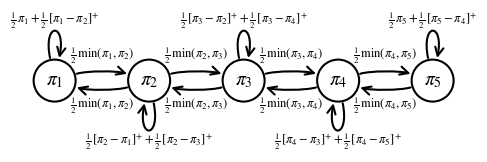

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


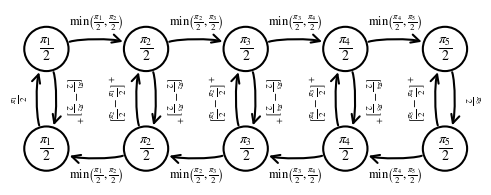

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
import numpy as np

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.fontset'] = 'stix'

def draw_nodes(G, pos, radius=0.3, node_color='#FFFFFF', edgecolors='black', linewidths=1.5, ax=None, zorder=3):
    """Draw circular nodes.

    Parameters
    ----------
    G : nx.Graph
        Graph whose nodes are drawn.
    pos : dict
        Mapping node -> (x,y) coordinates.
    radius : float
        Circle radius (data units).
    node_color : str or dict
        Fill color (single or per-node mapping).
    edgecolors : str
        Outline color.
    linewidths : float
        Outline width.
    ax : matplotlib.axes.Axes, optional
        Target axes (defaults current).
    zorder : int
        Drawing order.

    Returns
    -------
    ax : Axes
        Axes with patches added.
    """
    if ax is None:
        ax = plt.gca()
    fills = {n: node_color for n in G.nodes()} if isinstance(node_color, str) else node_color
    for n in G.nodes():
        x, y = pos[n]
        circ = patches.Circle((x, y), radius=radius, facecolor=fills[n], edgecolor=edgecolors,
                              linewidth=linewidths, zorder=zorder)
        ax.add_patch(circ)
    return ax

def draw_connection(p0, p1, angle_circ=0.0, angle_normal=None, strength=2.0, arrowstyle='->',
                    radius=0.3, color='black', linewidth=1.5, mutation_scale=10, zorder=4):
    """Create a curved arrow patch between two distinct points.

    Parameters
    ----------
    p0, p1 : tuple(float,float)
        Start and end coordinates.
    angle_circ : float
        Rotation applied to tangent vector near start.
    angle_normal : float or None
        Rotation for control vectors; defaults to angle_circ.
    strength : float
        Curvature intensity.
    arrowstyle : str
        Matplotlib arrowstyle.
    radius : float
        Node radius to offset start/end to avoid overlap.
    color : str
        Arrow color.
    linewidth : float
        Stroke width.
    mutation_scale : float
        Arrow head size scale.
    zorder : int
        Layer order.

    Returns
    -------
    patch : FancyArrowPatch
        Bezier arrow patch.
    """
    if angle_normal is None:
        angle_normal = angle_circ
    c_circ, s_circ = np.cos(angle_circ), np.sin(angle_circ)
    c_norm, s_norm = np.cos(angle_normal), np.sin(angle_normal)
    p0 = np.array(p0); p1 = np.array(p1)
    v = p1 - p0; v /= np.linalg.norm(v)
    rot_c = np.array([[c_circ, -s_circ],[s_circ, c_circ]])
    rot_n = np.array([[c_norm, -s_norm],[s_norm, c_norm]])
    rot_n2 = np.array([[c_norm, s_norm],[-s_norm, c_norm]])
    rot_c2 = np.array([[c_circ, s_circ],[-s_circ, c_circ]])
    v0 = rot_c.dot(v); v1 = rot_n.dot(v); v2 = rot_n2.dot(v); v3 = rot_c2.dot(v)
    p0 = p0 + 1.1 * radius * v0
    p3 = p1 - 1.1 * radius * v3
    p1c = p0 + 0.25 * strength * radius * v1
    p2c = p3 - 0.25 * strength * radius * v2
    verts = [p0, p1c, p2c, p3]
    path = Path(verts, [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    return patches.FancyArrowPatch(path=path, arrowstyle=arrowstyle, color=color, linewidth=linewidth,
                                    mutation_scale=mutation_scale, zorder=zorder)

def draw_loop(p0, angle_circ=np.pi/2, angle_dnormal=0.0, strength=2.0, arrowstyle='->',
              radius=0.3, color='black', linewidth=1.5, mutation_scale=10, zorder=4):
    """Create a self-loop arrow patch around a single node.

    Parameters mirror those of draw_connection but interpret angles as symmetric deviations
    forming a loop anchored at node position p0.
    """
    v0 = np.array([np.cos(angle_circ + angle_dnormal), np.sin(angle_circ + angle_dnormal)])
    v3 = np.array([np.cos(angle_circ - angle_dnormal), np.sin(angle_circ - angle_dnormal)])
    p0 = np.array(p0)
    p3 = p0 + 1.1 * radius * v3
    p0o = p0 + 1.1 * radius * v0
    p1c = p0o + 0.25 * strength * radius * v0
    p2c = p3 + 0.25 * strength * radius * v3
    verts = [p0o, p1c, p2c, p3]
    path = Path(verts, [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    return patches.FancyArrowPatch(path=path, arrowstyle=arrowstyle, color=color, linewidth=linewidth,
                                    mutation_scale=mutation_scale, zorder=zorder)

def draw_edges(G, pos, edgelist=None, angle_loop=np.pi/2, radius=0.3, arrowsize=15, width=1.5,
               arrowstyle='->', ax=None, zorder=4):
    """Draw all edges (connections + self-loops) as curved arrows.

    Parameters
    ----------
    G : nx.DiGraph
    pos : dict
        Node positions.
    edgelist : list[(u,v)] or None
        If None use all edges.
    angle_loop : float
        Base angle for loop orientation.
    radius : float
        Node radius for offset.
    arrowsize : float
        Mutation scale for arrow heads.
    width : float
        Line width.
    arrowstyle : str
        Style string.
    ax : Axes
        Target axes.
    zorder : int
        Layer order.
    """
    if ax is None:
        ax = plt.gca()
    if edgelist is None:
        edgelist = G.edges()
    for (u, v) in edgelist:
        if u == v:
            x0, y0 = pos[u]
            patch = draw_loop((x0, y0), angle_circ=angle_loop, angle_dnormal=0.2, radius=radius,
                               strength=7.0, arrowstyle=arrowstyle, color='black', linewidth=width,
                               mutation_scale=arrowsize, zorder=zorder)
        else:
            x1, y1 = pos[u]; x2, y2 = pos[v]
            patch = draw_connection((x1, y1), (x2, y2), radius=radius, angle_circ=0.3,
                                     arrowstyle=arrowstyle, color='black', linewidth=width,
                                     mutation_scale=arrowsize, zorder=zorder)
        ax.add_patch(patch)
    return ax

def draw_edge_labels(G, pos, edge_labels=None, font_size=12, label_pos=0.5, offset=0.08,
                     angle_loop=0.0, keep_upright=True, ax=None, bbox=None):
    """Place edge labels rotated along edge direction.

    Parameters
    ----------
    G : nx.Graph
    pos : dict
        Node positions.
    edge_labels : dict or None
        Mapping (u,v)->text; if None use 'label' attribute.
    font_size : int
        Label font size.
    label_pos : float
        Fraction along edge (0..1).
    offset : float
        Perpendicular offset (data units).
    angle_loop : float
        Angle for self-loop label placement direction.
    keep_upright : bool
        Flip rotation 180° if text would be upside down.
    ax : Axes
        Target axes.
    bbox : dict or None
        Matplotlib text bbox kwargs.
    """
    if edge_labels is None:
        edge_labels = nx.get_edge_attributes(G, 'label')
    if ax is None:
        ax = plt.gca()
    for (u, v), label in edge_labels.items():
        if u not in pos or v not in pos:
            continue
        if u == v:
            x, y = pos[u]
            xn, yn = np.cos(angle_loop), np.sin(angle_loop)
            ax.text(x + xn * offset, y + yn * offset, label, fontsize=font_size, ha='center',
                    va='bottom', rotation=0, bbox=bbox)
            continue
        p0 = np.array(pos[u]); p1 = np.array(pos[v])
        pm = p0 + label_pos * (p1 - p0)
        vdir = p1 - p0; vdir /= np.linalg.norm(vdir)
        angle = np.degrees(np.arctan2(vdir[1], vdir[0]))
        p = pm + offset * np.array([-vdir[1], vdir[0]])
        if keep_upright and (angle > 90 or angle < -90):
            angle += 180
        ax.text(p[0], p[1], label, fontsize=font_size, rotation=angle, rotation_mode='anchor',
                ha='center', va='center', bbox=bbox)
    return ax

def draw_markov_chain(G):
    """Render a Markov chain graph with optional lifted two-row layout.

    Layout rules:
    - If any node starts with '+', treat as lifted: separate rows.
    - Otherwise single row for metastate line.

    Self-loop styling: numeric node names assumed for parity classification; lifted graphs
    currently have no self-loops so logic degrades harmlessly.

    Returns
    -------
    fig, ax : (Figure, Axes)
        Matplotlib figure and axes containing the drawing.
    """
    radius = 1.0
    pos_down = [n for n in G.nodes() if not n.startswith('+')]
    pos_up = [n for n in G.nodes() if n.startswith('+')]
    pos = {node: (i * 4.5 * radius, 0) for i, node in enumerate(pos_down)}
    n = len(pos_down)
    if pos_up:
        pos.update({node: (i * 4.5 * radius, 4.5 * radius) for i, node in enumerate(pos_up)})
    if pos_up:
        height = 6 * 4.0 / (2 * n + 1)
        fig, ax = plt.subplots(figsize=(6, height))
        ax.set_ylim(-1.0 * radius, 6.0 * radius)
    else:
        height = 6 * 2.5 / (2 * n + 1)
        fig, ax = plt.subplots(figsize=(6, height))
        ax.set_ylim(-2.5 * radius, 2.5 * radius)
    ax.set_xlim(-1.5 * radius, (4.5 * (n - 1) + 1.5) * radius)
    ax.set_aspect('equal', adjustable='datalim')
    draw_nodes(G, pos, radius=radius, ax=ax)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=14, ax=ax)
    loop_labels_even, loops_even = {}, []
    loop_labels_odd, loops_odd = {}, []
    conn_labels, connections = {}, []
    for u, v in G.edges():
        if u == v:
            try:
                idx = int(u)
            except ValueError:
                # Non-numeric self-loop; treat as odd group
                idx = 1
            if idx % 2 == 0:
                loop_labels_even[(u, v)] = G[u][v]['label']; loops_even.append((u, v))
            else:
                loop_labels_odd[(u, v)] = G[u][v]['label']; loops_odd.append((u, v))
        else:
            conn_labels[(u, v)] = G[u][v]['label']; connections.append((u, v))
    draw_edges(G, pos, radius=radius, edgelist=connections, ax=ax, angle_loop=1.5 * np.pi)
    draw_edge_labels(G, pos, edge_labels=conn_labels, font_size=9, offset=1.2 * radius, ax=ax)
    draw_edges(G, pos, radius=radius, edgelist=loops_even, ax=ax, angle_loop=0.5 * np.pi)
    draw_edge_labels(G, pos, edge_labels=loop_labels_even, font_size=9, offset=2.4 * radius, ax=ax, angle_loop=0.5 * np.pi)
    draw_edges(G, pos, radius=radius, edgelist=loops_odd, ax=ax, angle_loop=1.5 * np.pi)
    draw_edge_labels(G, pos, edge_labels=loop_labels_odd, font_size=9, offset=3.4 * radius, ax=ax, angle_loop=1.5 * np.pi)
    ax.axis('off')
    return fig, ax

# Generate and save figures
OUTPUT_PREFIX = "mcmc"
graph = create_markov_chain_graph_metropolis()
fig, ax = draw_markov_chain(graph)
fig.savefig(f"{OUTPUT_PREFIX}_metropolis.pdf", bbox_inches="tight")
plt.show()
graph = create_markov_chain_graph_lifted()
fig, ax = draw_markov_chain(graph)
fig.savefig(f"{OUTPUT_PREFIX}_lifted.pdf", bbox_inches="tight")
plt.show()

## Output
Generated files:
- mcmc_metropolis.pdf
- mcmc_lifted.pdf
Adjust `n` in the construction calls or `OUTPUT_PREFIX` to regenerate variants.

## Event-Chain Hard-Disk Demonstration
This section illustrates a simplified rejection-free event-chain (ECMC) move for 2D hard disks with periodic boundaries.

A chain:
- Picks an active particle and an axis (x or y).
- Moves it deterministically with unit speed until a collision or chain length exhaustion.
- Transfers activity to the collision partner and continues.
- Terminates once cumulative displacement equals the sampled chain length.

The implementation here is minimal: axis-aligned motion only, positive direction, and a direct collision time computation ignoring negative-time roots.

### Implementation Notes
- Positions wrapped in [0,L).
- Collision criterion: solve along chosen axis using geometry; perpendicular separation must be < 2r.
- Neighbor images implicitly handled by minimum-image conventions.
- No cell lists (O(N) scan) for clarity; acceptable for small demonstrative systems.
- Numba used for speed without altering core logic.

In [3]:
# Minimal 2D hard-disk event-chain (axis-aligned, speed=1), with PBC
# - positions in data coordinates (box [0,L)×[0,L))
# - collisions computed with minimum-image + neighbor images
# - chain direction fixed during a chain (+x or +y)
# Requires: numba, numpy

import numpy as np
from numba import njit

# -----------------------------
# Geometry / PBC helpers
# -----------------------------

@njit
def pbc_wrap(x, L):
    # Wrap into [0, L)
    x -= np.floor(x / L) * L
    return x

@njit
def min_image(dx, L):
    # Minimum image for a single component
    dx -= np.floor(dx / L + 0.5) * L
    return dx

# -----------------------------
# Collision time along axis
# -----------------------------
# Active particle i moves with v=(±1,0) or (0,±1). Others are static during that time.
# For each other particle j, we try neighbor images n_x,n_y in {-1,0,1},
# find the smallest positive root t of:
#   (dx + vx t)^2 + (dy + vy t)^2 = (2r)^2
# Here vy=0 for x-direction motion (and vx=0 for y-direction motion).

@njit
def earliest_collision_axis(i, pos, L, r, axis=0, dl=np.inf):
    """
    Returns (t_min, j_min) for the next collision of active i moving
    along 'axis' (0=x, 1=y) with given sign (+1 or -1).
    If no collision ahead: returns (np.inf, -1).
    """
    N = pos.shape[0]
    diameter = 2.0 * r
    R2 = diameter * diameter

    axis_perp = 1 if axis == 0 else 0

    xi, yi = pos[i, axis], pos[i, axis_perp]
    t_best = np.inf
    j_best = -1

    for j in range(N):
        if j == i:
            continue
        dx = pbc_wrap((pos[j, axis]- xi),L)
        dy = min_image((pos[j, axis_perp]- yi),L)
        dy_sq = dy * dy
        if dy_sq > R2:
            continue  # too far in perpendicular direction
        if dx > dl + diameter:
            continue  # too far in parallel direction
        t_hit = dx - np.sqrt(R2 - dy_sq)
        if t_hit < t_best:
            t_best = t_hit
            j_best = j
    return t_best, j_best


# -----------------------------
# Move one particle with PBC
# -----------------------------
@njit
def move_particle(i, pos, L, axis, dt):
    if axis == 0:
        pos[i, 0] = pbc_wrap(pos[i, 0] + dt, L)
    else:
        pos[i, 1] = pbc_wrap(pos[i, 1] + dt, L)

# -----------------------------
# Single event-chain
# -----------------------------
@njit
def run_event_chain(pos, L, r, chain_len, start_idx, axis):
    """
    Run one event chain:
      - active = start_idx
      - direction: 'axis'
      - move until total displacement = chain_len
      - on collision, activity hops to the hit particle
    Returns last active index (not strictly needed, but handy).
    """
    remaining = chain_len
    active = start_idx
    indcs = []
    pos_chain = []

    while remaining > 0.0:
        t_col, j_hit = earliest_collision_axis(active, pos, L, r, axis, dl=remaining)

        if t_col > remaining or j_hit == -1 or not np.isfinite(t_col):
            # No collision before chain end: move the rest and finish
            indcs.append(active)
            pos_chain.append(pos[active].copy())
            move_particle(active, pos, L, axis, remaining)
            remaining = 0.0
        else:
            # Move to collision time, then hop activity
            indcs.append(active)
            pos_chain.append(pos[active].copy())
            move_particle(active, pos, L, axis, t_col)
            remaining -= t_col
            active = j_hit  # activity passes on
    return active, indcs, pos_chain

# -----------------------------
# Initialization helpers
# -----------------------------
def init_square_lattice(n, L, r):
    """
    Place n*n disks on a square lattice inside [0,L)^2.
    Lattice spacing is L/n (assumes n_x == n_y for simplicity).
    Requires that spacing >= 2r to avoid overlaps.
    """
    N = n * n
    pos = np.zeros((N, 2), dtype=np.float64)

    a = L / n
    if a < 2.0 * r:
        raise ValueError("Lattice spacing smaller than 2r -> overlaps.")

    k = 0
    for iy in range(n):
        for ix in range(n):
            pos[k, 0] = (ix + 0.5) * a
            pos[k, 1] = (iy + 0.5) * a
            k += 1

    return pos

### Visualization Helper
`plot_disks` draws disks, highlights those touched during a chain, and annotates hop order.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.fontset'] = 'stix'

def plot_disks(pos, L, r, indcs=None, ax=None, fontsize=12, linewidth=1.2):
    """
    pos   : (N,2) array of coordinates
    L     : box size
    r     : disk radius
    indcs : list of particle indices in order of the event chain
    """
    if ax is None:
        ax = plt.gca()

    N = pos.shape[0]
    pos = np.asarray(pos)

    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect('equal', adjustable='box')

    # Colors
    normal_color = 'lightblue'
    highlight_color = 'lightcoral'   # soft red

    # Map indices to labels 1,2,3,... for convenience
    label_map = {}
    if indcs is not None:
        for k, idx in enumerate(indcs):
            label_map[idx] = k + 1

    for i in range(N):
        x, y = pos[i]
        # choose color
        facecolor = highlight_color if i in label_map else normal_color

        # periodic offsets (only draw visible images)
        x_offsets = [0.0]
        y_offsets = [0.0]
        if x - r < 0.0:   x_offsets.append(L)
        if x + r > L:     x_offsets.append(-L)
        if y - r < 0.0:   y_offsets.append(L)
        if y + r > L:     y_offsets.append(-L)

        for dx in x_offsets:
            for dy in y_offsets:
                disk = patches.Circle((x + dx, y + dy), r,
                                      facecolor=facecolor,
                                      edgecolor='black',
                                      linewidth=linewidth)
                disk.set_clip_on(True)
                ax.add_patch(disk)

        # draw label only on primary (non-offset) position
        if i in label_map:
            ax.text(x, y,
                    rf"${label_map[i]}$",
                    color='black',
                    fontsize=fontsize,
                    ha='center', va='center')

    # Clean axes (keep frame, no ticks)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_xmargin(0)
    ax.set_ymargin(0)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(linewidth)

    return ax


### Running Multiple Chains
We thermalize (qualitatively) by executing many short chains with random start particle and axis.

In [11]:
np.random.seed(123)

# System parameters
n = 8         # 64 disks
L = 16.0    # box length
r = 0.9              # disk radius (spacing must be >= 2r)

pos = init_square_lattice(n, L, r)
N = pos.shape[0]


# Event-chain parameters
max_chain = 2.0  # sample chain length uniformly in (0, max_chain)
is_mc = False
# Run a few chains
for step in range(10007):
    if is_mc:
        start_idx = np.random.randint(0, N)
        axis = np.random.randint(0, 2)       # 0=x, 1=y
        chain_len = np.random.rand() * max_chain
    else:
        start_idx = step % N
        axis = step % 2
        chain_len = max_chain
    active, indcs, pos_chain = run_event_chain(pos, L, r, chain_len, start_idx, axis)


### Visualizing One Chain
We choose the particle nearest (0.25L, 0.5L) along the x-axis and display positions before and after the chain (annotating visitation order).

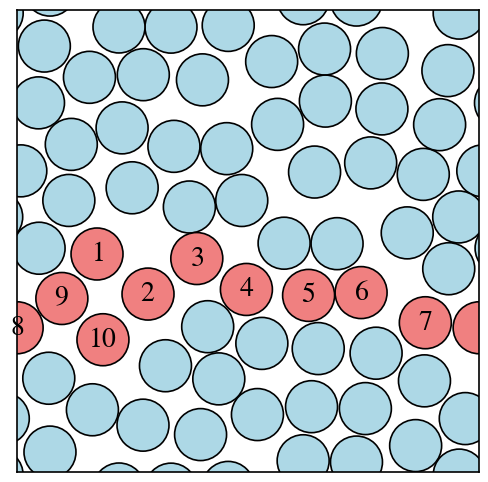

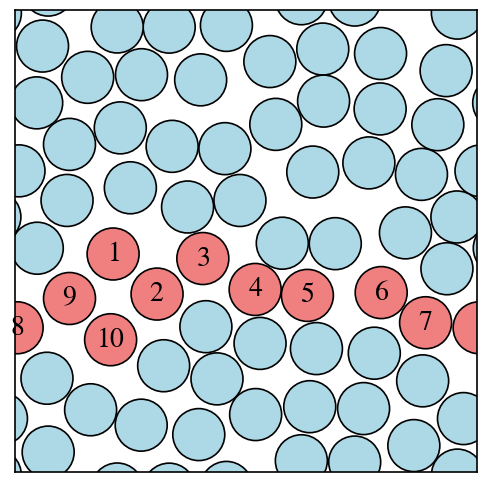

In [12]:
# for vizualization, run one more chain and keep track of positions
p_start = np.array([0.25*L, 0.5*L]).reshape(1,2)
start_idx = np.sum((pos - p_start)**2, axis=1).argmin()
axis = 0
chain_len = L/5.0
active, indcs, pos_chain = run_event_chain(pos, L, r, chain_len, start_idx, axis)

fontsize = 20
fig, ax = plt.subplots(figsize=(6, 6))
pos_old = pos.copy()
for k, idx in enumerate(indcs):
    pos_old[idx] = pos_chain[k]
plot_disks(pos_old, L, r, indcs, ax=ax, fontsize=fontsize)
plt.show()
fig.savefig(f"event_chain_before.pdf")

fig, ax = plt.subplots(figsize=(6, 6))
plot_disks(pos, L, r, indcs, ax=ax, fontsize=fontsize)
plt.show()
fig.savefig(f"event_chain_after.pdf")



### Visualizing 100% Deterministic ECMC

Starting with a lattice arrangement we iterate through the list of particles and alternatingly move displace the active particle right or up.

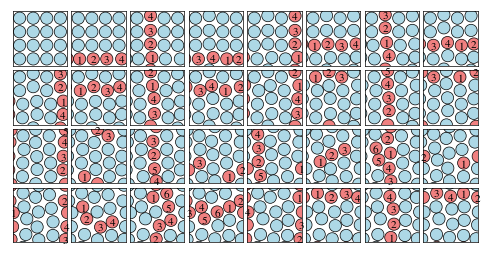

In [7]:
# System parameters
n = 4      # 16 disks
L = 8.0    # box length
r = 0.9    # disk radius (spacing must be >= 2r)

pos = init_square_lattice(n, L, r)
N = pos.shape[0]

# Event-chain parameters
max_chain = 0.7*np.sqrt(2.0)  # sample chain length uniformly in (0, max_chain)
is_mc = False
fontsize = 8
linewidth = 0.5
# Run a few chains
fig, axs = plt.subplots(4, 8, figsize=(6, 3.0), gridspec_kw=dict(wspace=0.08, hspace=0.08))
plot_disks(pos, L, r, ax=axs[0,0], fontsize=fontsize, linewidth=linewidth)
for step in range(31):
    ax = axs[(step+1)//8, (step+1)%8]
    if is_mc:
        start_idx = np.random.randint(0, N)
        axis = np.random.randint(0, 2)       # 0=x, 1=y
        chain_len = np.random.rand() * max_chain
    else:
        start_idx = step % N
        axis = step % 2
        chain_len = max_chain
    active, indcs, pos_chain = run_event_chain(pos, L, r, chain_len, start_idx, axis)
    plot_disks(pos, L, r, indcs, ax=ax, fontsize=fontsize, linewidth=linewidth)

plt.show()
fig.savefig(f"event_chain_deterministic.pdf")
